In [1]:
import warnings
import sklearn.metrics as metrics
from utility import split_sequence
from dataset import suny_international
import tensorflow as tf

In [2]:
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import LSTM
from keras.layers import Dense,Input

Using TensorFlow backend.


In [40]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

In [41]:
def vanilla_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [42]:
n_steps=20
n_features= 1

In [43]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [44]:
df=suny_international.load_data()['GHI']

In [45]:
y = df.resample('D').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

In [109]:
print(len(decomposition.resid))
print(len(decomposition.trend))
print(len(decomposition.seasonal))
print(len(decomposition.observed))

1461
1461
1461
1461


In [141]:
df_train_trend,df_test_trend = suny_international.train_test_split(decomposition.trend)
df_train_seasonal,df_test_seasonal = suny_international.train_test_split(decomposition.seasonal)
df_train_residual,df_test_residual = suny_international.train_test_split(decomposition.resid)

In [143]:
df_test_trend.isna().sum()

3

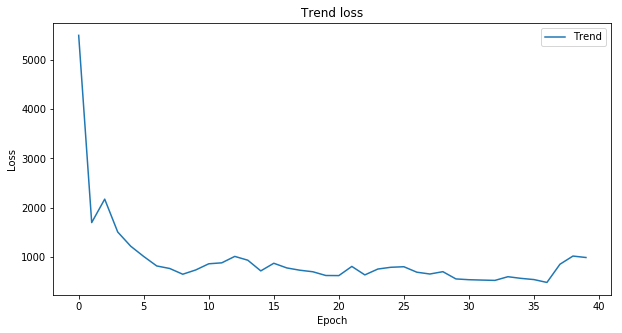

994.4873433108654


In [144]:
df_train_trend=df_train_trend.dropna()

# X, y = split_sequence(df_train_trend, n_steps)
# X = X.reshape((X.shape[0], X.shape[1], n_features))

X, y = split_sequence(df_train_trend, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))
model=vanilla_lstm(n_steps, n_features)
history_trend=model.fit(X,y,epochs=40,verbose=False)
model.save('models/simple_rnn_trend.h5')
plt.plot(history_trend.history['loss'])
plt.title('Trend loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Trend'], loc='upper right')
plt.show()
print(history_trend.history['loss'][-1])

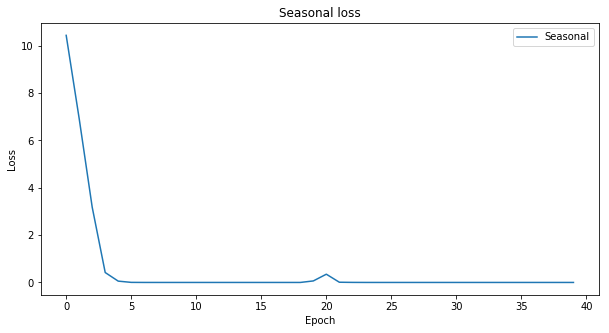

2.633340055518454e-12


In [72]:
df_train_seasonal=df_train_seasonal.dropna()

X, y = split_sequence(df_train_seasonal, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))
model=vanilla_lstm(n_steps, n_features)
history_seasonal=model.fit(X,y,epochs=40,verbose=False)
model.save('models/simple_rnn_seasonal.h5')
plt.plot(history_seasonal.history['loss'])
plt.title('Seasonal loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Seasonal'], loc='upper right')
plt.show()
print(history_seasonal.history['loss'][-1])

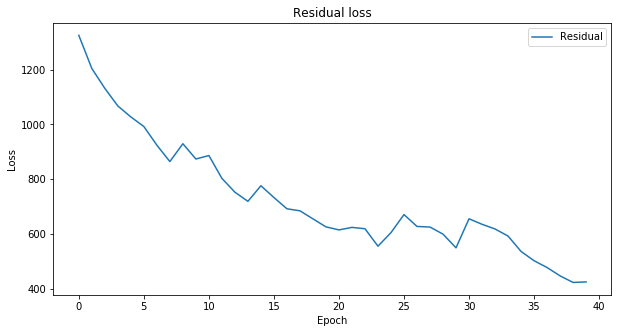

425.13285388217724


In [71]:
df_train_residual=df_train_residual.dropna()

X, y = split_sequence(df_train_residual, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))
model=vanilla_lstm(n_steps, n_features)
history_residual=model.fit(X,y,epochs=40,verbose=False)
model.save('models/simple_rnn_residual.h5')
plt.plot(history_residual.history['loss'])
plt.title('Residual loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Residual'], loc='upper right')
plt.show()
print(history_residual.history['loss'][-1])

In [95]:
from keras.models import load_model
model_trend = load_model('models/simple_rnn_trend.h5')
model_seasonal = load_model('models/simple_rnn_seasonal.h5')
model_residual = load_model('models/simple_rnn_residual.h5')

In [132]:
df_test_trend = df_test_trend.dropna()
X, y = split_sequence(df_test_trend, n_steps)
Y_test = y
X = X.reshape((X.shape[0], X.shape[1], n_features))
trend_pred = model_trend.predict(X)

In [133]:
df_test_seasonal = df_test_seasonal.dropna()
X, y = split_sequence(df_test_seasonal, n_steps)
Y_test = Y_test + y
X = X.reshape((X.shape[0], X.shape[1], n_features))
seasonal_pred = model_seasonal.predict(X)


ValueError: operands could not be broadcast together with shapes (342,) (345,) 

In [124]:
df_test_residual = df_test_residual.dropna()

X, y = split_sequence(df_test_residual, n_steps)
Y_test = Y_test + y
X = X.reshape((X.shape[0], X.shape[1], n_features))
residual_pred = model_residual.predict(X)
y.shape

(345,)

In [130]:
Y_test.shape
Y_predicted = trend_pred + seasonal_pred + residual_pred
Y_predicted.shape

(345, 1)

In [131]:
metrics.mean_squared_error(y_true=Y_test,y_pred=Y_predicted)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

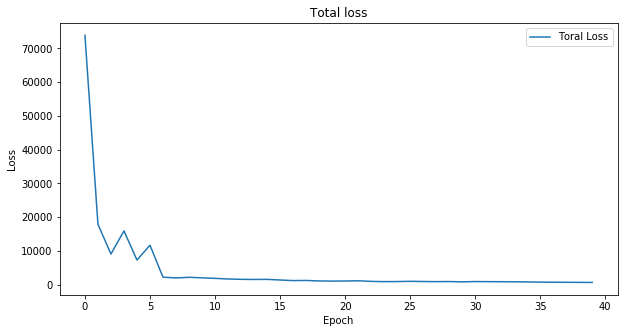

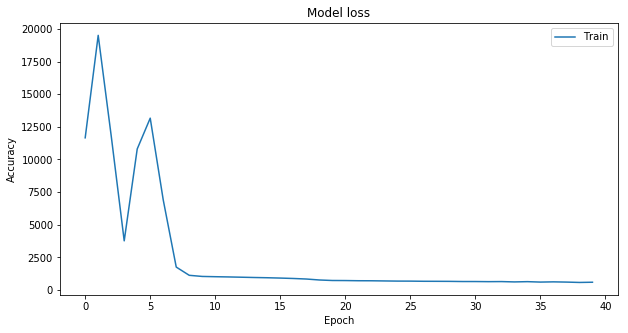

In [8]:
model=vanilla_lstm(n_steps, n_features)
history=model.fit(X,y,epochs=40,verbose=False)
model.save('models/simple_rnn.h5')
print(history.history['loss'][-1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
3440.1598347279205


In [9]:
X, y = split_sequence(df_test, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))
y_pred = model.predict(X)
metrics.mean_squared_error(y_true=y,y_pred=y_pred)

4296.363000494793

In [36]:
from keras.layers import concatenate

def lstm_with_weather(n_steps, n_features):
    temporal_input = Input(shape=(n_steps,1))
    lstm  = LSTM(50, activation='relu')(temporal_input)
    non_temporal_input =Input(shape=(n_features,))
    dense1 = Dense(units=20, activation='relu')(non_temporal_input) 
    all_info = concatenate(inputs=[lstm, dense1])
    dense3 = Dense(units=10, activation='relu')(all_info)
    output = Dense(units=1)(dense3)
    model = Model([temporal_input, non_temporal_input], output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [37]:
n_steps=20
n_features= len(suny_international.atmospheric_factors)

In [32]:
X_nontemporal=np.array([*(df_train[factor] for factor in suny_international.atmospheric_factors)]).T
X_nontemporal=X_nontemporal[n_steps:]
X_temporal, y = split_sequence(df_train['GHI'], n_steps)
X_temporal = X_temporal.reshape((X_temporal.shape[0], X_temporal.shape[1], 1))
X=[X_temporal,X_nontemporal]

In [38]:
model=lstm_with_weather(n_steps,n_features)
history=model.fit(X,y,epochs=40,verbose=False)
model.save('models/simple_rnn_atmospheric.h5')
print(history.history['loss'][-1])

Epoch 1/40
52588/52588 [==============================] - 46s 880us/step - loss: 16691.6269
Epoch 2/40
52588/52588 [==============================] - 47s 893us/step - loss: 4868.7353
Epoch 3/40
52588/52588 [==============================] - 44s 843us/step - loss: 3943.8434
Epoch 4/40
52588/52588 [==============================] - 39s 746us/step - loss: 3520.9397
Epoch 5/40
52588/52588 [==============================] - 43s 817us/step - loss: 3341.6771
Epoch 6/40
52588/52588 [==============================] - 37s 700us/step - loss: 3133.2629
Epoch 7/40
52588/52588 [==============================] - 34s 640us/step - loss: 3072.4762
Epoch 8/40
52588/52588 [==============================] - 37s 712us/step - loss: 3037.2125
Epoch 9/40
52588/52588 [==============================] - 39s 749us/step - loss: 3029.4447
Epoch 10/40
52588/52588 [==============================] - 46s 883us/step - loss: 3428.0865
Epoch 11/40
52588/52588 [==============================] - 46s 878us/step - loss: 2983.5

In [40]:
X_nontemporal=np.array([*(df_test[factor] for factor in suny_international.atmospheric_factors)]).T
X_nontemporal=X_nontemporal[n_steps:]
X_temporal, y = split_sequence(df_test['GHI'], n_steps)
X_temporal = X_temporal.reshape((X_temporal.shape[0], X_temporal.shape[1], 1))
X=[X_temporal,X_nontemporal]

In [41]:
y_pred = model.predict(X)
metrics.mean_squared_error(y_true=y,y_pred=y_pred)

2494.159641600965